Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# SECTION 1: Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# Section 2 : Dataset

## Preparing the dataset (Kinematic)

In [ ]:
import numpy as np
import json

# -----------------------------
# 1. LOAD DATA
# -----------------------------
DATA_DIR = "/content/drive/MyDrive/kinematic_dataset_final/stgcn_input/"

data_arr = np.load(DATA_DIR + "data.npy")       # (N, 9, T, V)
labels_arr = np.load(DATA_DIR + "labels.npy")   # (N,)

with open(DATA_DIR + "meta.json", 'r') as f:
    meta = json.load(f)

print("Loaded data:", data_arr.shape)
print("Loaded labels:", labels_arr.shape)
print("Meta keys:", meta.keys())

# -----------------------------
# 2. EXTRACT DIMENSIONS
# -----------------------------
N, C, T, V = data_arr.shape
print(f"N={N}, C={C}, T={T}, V={V}")

# -----------------------------
# 3. PREPARE LSTM INPUT FORMAT
# -----------------------------
# Convert (N, C, T, V) → (N, T, C*V)
X = data_arr.transpose(0, 2, 1, 3).reshape(N, T, C * V)

print("LSTM-ready X shape:", X.shape)  # Expected: (N, T, 9*V)


Loaded data: (932, 3, 100, 59)
Loaded labels: (932,)
Meta keys: dict_keys(['joint_names', 'edge_list', 'label2idx', 'target_frames', 'center_root', 'normalize'])
N=932, C=3, T=100, V=59
LSTM-ready X shape: (932, 100, 177)


## Reshaping the dataset for LSTM


In [ ]:
X = data_arr.transpose(0, 2, 1, 3).reshape(N, T, 3*V)


# Section 3: Working with motion Features

## Adding motion features

In [ ]:
import numpy as np

def add_motion_features_batch(X):
    """
    X shape: (N, 3, T, V)
    Returns: (N, 9, T, V)
    """
    N, C, T, V = X.shape
    assert C == 3, "Expected 3 channels (x,y,z) before motion features"

    X_new = np.zeros((N, 9, T, V), dtype=np.float32)

    for i in range(N):
        pos = X[i]                       # (3, T, V)

        # Velocity
        vel = np.zeros_like(pos)
        vel[:, 1:] = pos[:, 1:] - pos[:, :-1]

        # Acceleration
        acc = np.zeros_like(pos)
        acc[:, 1:] = vel[:, 1:] - vel[:, :-1]

        # Concatenate: [pos, vel, acc]
        X_new[i, 0:3] = pos
        X_new[i, 3:6] = vel
        X_new[i, 6:9] = acc

    return X_new


## reshaping the motion features

In [ ]:
X_mf = add_motion_features_batch(data_arr)

print("New shape with motion features:", X_mf.shape)


New shape with motion features: (932, 9, 100, 59)


## Convert for LSTM input (now using 9 channels)

In [ ]:
N, C, T, V = X_mf.shape   # C should now be 9

X_lstm = X_mf.transpose(0, 2, 1, 3).reshape(N, T, C * V)

print("Final LSTM input shape:", X_lstm.shape)



Final LSTM input shape: (932, 100, 531)


## Saving the motion-feature version

In [ ]:
np.save(DATA_DIR + "data_with_motion.npy", X_mf)


# SECTION 4: Augmentations for LSTM

In [ ]:
def augment_lstm_sample(x, V, p=0.5):
    # x: (T, 9*V)
    T, F = x.shape
    sample = x.reshape(T, V, 9)

    # Gaussian noise
    if np.random.rand() < p:
        sample += np.random.normal(0, 0.01, sample.shape)

    return sample.reshape(T, F)


# SECTION 5: Mixup

In [ ]:
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    return mixed_x, y, y[idx], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# SECTION 6: PyTorch Dataset

In [ ]:
class LSTMDataset(Dataset):
    def __init__(self, X, y, V, training=False):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.training = training
        self.V = V

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.training:
            x = augment_lstm_sample(x, self.V)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y)


# SECTION 7: Attention-Based LSTM Model

Channel Attention

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, dim, reduction=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, dim // reduction),
            nn.ReLU(),
            nn.Linear(dim // reduction, dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(x.mean(1))  # (N,F)
        return x * w.unsqueeze(1)


Temporal Attention

In [ ]:
class TemporalAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.fc(x), dim=1)
        out = torch.sum(weights * x, dim=1)
        return out


Final LSTM Model

In [ ]:
class MotionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super().__init__()

        self.chan_att = ChannelAttention(input_dim)

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=True
        )

        self.temp_att = TemporalAttention(hidden_dim * 2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.chan_att(x)
        out, _ = self.lstm(x)
        out = self.temp_att(out)
        logits = self.fc(out)
        return logits


# SECTION 8: Train/Val Split + DataLoaders

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X_lstm, labels_arr, test_size=0.2, stratify=labels_arr, random_state=42
)

train_ds = LSTMDataset(X_train, y_train, V, training=True)
val_ds = LSTMDataset(X_val, y_val, V, training=False)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)


# SECTION 9: Training Setup

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MotionLSTM(
    input_dim=9*V,
    hidden_dim=256,
    num_layers=2,
    num_classes=len(np.unique(labels_arr)),
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)


# SECTION 10: Training Loop

In [ ]:
def train_epoch():
    model.train()
    total = 0
    correct = 0
    running_loss = 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        # Mixup
        xb_mix, y_a, y_b, lam = mixup_data(xb, yb)

        optimizer.zero_grad()
        logits = model(xb_mix)
        loss = mixup_criterion(criterion, logits, y_a, y_b, lam)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * xb.size(0)

    return running_loss / len(train_ds)


def eval_epoch():
    model.eval()
    total = 0
    correct = 0
    preds = []
    labels = []

    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1)

            preds.extend(pred.cpu().numpy())
            labels.extend(yb.cpu().numpy())

    acc = (np.array(preds) == np.array(labels)).mean()
    return acc, preds, labels


# SECTION 11: Train Model

In [ ]:
EPOCHS = 80
best_acc = 0

for epoch in range(EPOCHS):
    loss = train_epoch()
    acc, preds, labels = eval_epoch()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss {loss:.4f} | Val Acc {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_lstm.pth")

print("Best Val Acc:", best_acc)


Epoch 1/80 | Loss 1.9437 | Val Acc 0.2032
Epoch 2/80 | Loss 1.9212 | Val Acc 0.2299
Epoch 3/80 | Loss 1.8730 | Val Acc 0.2032
Epoch 4/80 | Loss 1.9160 | Val Acc 0.2674
Epoch 5/80 | Loss 1.8418 | Val Acc 0.2781
Epoch 6/80 | Loss 1.7879 | Val Acc 0.2781
Epoch 7/80 | Loss 1.7885 | Val Acc 0.2941
Epoch 8/80 | Loss 1.7800 | Val Acc 0.3583
Epoch 9/80 | Loss 1.6880 | Val Acc 0.4064
Epoch 10/80 | Loss 1.6485 | Val Acc 0.3904
Epoch 11/80 | Loss 1.5473 | Val Acc 0.4492
Epoch 12/80 | Loss 1.4775 | Val Acc 0.4759
Epoch 13/80 | Loss 1.4349 | Val Acc 0.4706
Epoch 14/80 | Loss 1.5282 | Val Acc 0.4225
Epoch 15/80 | Loss 1.5232 | Val Acc 0.4492
Epoch 16/80 | Loss 1.4108 | Val Acc 0.4759
Epoch 17/80 | Loss 1.3188 | Val Acc 0.4706
Epoch 18/80 | Loss 1.2942 | Val Acc 0.4652
Epoch 19/80 | Loss 1.2026 | Val Acc 0.4813
Epoch 20/80 | Loss 1.1536 | Val Acc 0.5241
Epoch 21/80 | Loss 1.0534 | Val Acc 0.5241
Epoch 22/80 | Loss 1.0538 | Val Acc 0.5294
Epoch 23/80 | Loss 0.9776 | Val Acc 0.5187
Epoch 24/80 | Loss 0

# SECTION 12: Confusion Matrix

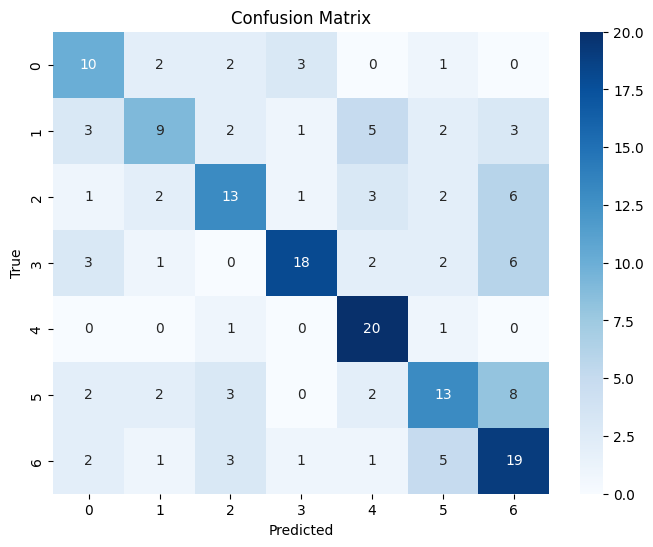


Classification Report:

              precision    recall  f1-score   support

           0       0.48      0.56      0.51        18
           1       0.53      0.36      0.43        25
           2       0.54      0.46      0.50        28
           3       0.75      0.56      0.64        32
           4       0.61      0.91      0.73        22
           5       0.50      0.43      0.46        30
           6       0.45      0.59      0.51        32

    accuracy                           0.55       187
   macro avg       0.55      0.55      0.54       187
weighted avg       0.55      0.55      0.54       187



In [ ]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(labels, preds))


In [ ]:
model.load_state_dict(torch.load("best_lstm.pth", map_location=device))
model.eval()


MotionLSTM(
  (chan_att): ChannelAttention(
    (fc): Sequential(
      (0): Linear(in_features=531, out_features=66, bias=True)
      (1): ReLU()
      (2): Linear(in_features=66, out_features=531, bias=True)
      (3): Sigmoid()
    )
  )
  (lstm): LSTM(531, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (temp_att): TemporalAttention(
    (fc): Linear(in_features=512, out_features=1, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

Evaluation on Validation Set

In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))


              precision    recall  f1-score   support

           0     0.5385    0.3889    0.4516        18
           1     0.5667    0.6800    0.6182        25
           2     0.7273    0.2857    0.4103        28
           3     0.6897    0.6250    0.6557        32
           4     0.7037    0.8636    0.7755        22
           5     0.6000    0.7000    0.6462        30
           6     0.4524    0.5938    0.5135        32

    accuracy                         0.5936       187
   macro avg     0.6112    0.5910    0.5816       187
weighted avg     0.6110    0.5936    0.5825       187



Overall Accuracy

In [ ]:
acc = (np.array(all_labels) == np.array(all_preds)).mean()
print("Final Validation Accuracy:", acc)


Final Validation Accuracy: 0.5935828877005348


Per-Class Accuracy

In [ ]:
import numpy as np

labels = np.array(all_labels)
preds = np.array(all_preds)

unique_classes = np.unique(labels)

for cl in unique_classes:
    idx = labels == cl
    class_acc = (labels[idx] == preds[idx]).mean()
    print(f"Class {cl}: Accuracy = {class_acc:.3f}")


Class 0: Accuracy = 0.389
Class 1: Accuracy = 0.680
Class 2: Accuracy = 0.286
Class 3: Accuracy = 0.625
Class 4: Accuracy = 0.864
Class 5: Accuracy = 0.700
Class 6: Accuracy = 0.594


Probability Inspection for Debugging


This helps to check if the model is:

Overconfident

Always predicting one label

Producing uniform probabilities

In [ ]:
softmax = nn.Softmax(dim=1)

model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_dl))
    xb = xb.to(device)
    probs = softmax(model(xb)).cpu().numpy()

print("Probabilities for first batch sample:")
print(probs[0])


Probabilities for first batch sample:
[0.01628284 0.04607429 0.0465103  0.09521506 0.01394125 0.3978706
 0.38410574]


In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())


Final Validation Accuracy

In [ ]:
import numpy as np
final_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print("Final Validation Accuracy:", final_acc)


Final Validation Accuracy: 0.5935828877005348


In [ ]:
idx = 0  # choose any index from validation set
x = X_val[idx]  # numpy array
y_true = y_val[idx]

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # (1,T,F)

model.eval()
with torch.no_grad():
    logits = model(x_tensor)
    pred = torch.argmax(logits, dim=1).item()

print("True Label:", y_true)
print("Predicted Label:", pred)


True Label: 5
Predicted Label: 5


# Section 13: Baseline Model Testing

Cross validation

In [ ]:
# ===============================================================
# 10. K-FOLD CROSS VALIDATION (REPLACES TRAIN/VAL SPLIT)
# ===============================================================
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import torch

K = 5  # number of folds
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

fold_accuracies = []
fold_reports = []
fold_confusions = []

def train_one_epoch(model, train_dl, optimizer, scheduler):
    model.train()
    running_loss = 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        xb_mix, y_a, y_b, lam = mixup_data(xb, yb)

        optimizer.zero_grad()
        logits = model(xb_mix)
        loss = mixup_criterion(criterion, logits, y_a, y_b, lam)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item() * xb.size(0)

    return running_loss / len(train_dl.dataset)

def eval_model(model, val_dl):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred)
            labels.extend(yb.numpy())

    acc = accuracy_score(labels, preds)
    return acc, preds, labels


# ------------------------------
# K-FOLD LOOP
# ------------------------------
fold = 1
for train_idx, val_idx in skf.split(X_lstm, labels_arr):
    print(f"\n============================")
    print(f"▶ FOLD {fold}/{K}")
    print(f"============================\n")

    # Build dataset for this fold
    X_train, X_val = X_lstm[train_idx], X_lstm[val_idx]
    y_train, y_val = labels_arr[train_idx], labels_arr[val_idx]

    train_ds = LSTMDataset(X_train, y_train, V, training=True)
    val_ds   = LSTMDataset(X_val, y_val, V, training=False)

    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_dl   = DataLoader(val_ds, batch_size=32)

    # Reinitialize a fresh model for each fold
    model = MotionLSTM(
        input_dim=9*V,
        hidden_dim=256,
        num_layers=2,
        num_classes=len(np.unique(labels_arr)),
        dropout=0.5
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    best_acc = 0
    EPOCHS = 40  # use fewer epochs because we train K times

    for epoch in range(EPOCHS):
        loss = train_one_epoch(model, train_dl, optimizer, scheduler)
        acc, preds, labels = eval_model(model, val_dl)
        print(f"Fold {fold} | Epoch {epoch+1}/{EPOCHS} | Loss {loss:.4f} | Val Acc {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_preds = preds
            best_labels = labels

    print(f"\n✔ Best Accuracy for Fold {fold}: {best_acc:.4f}")

    # Save results
    fold_accuracies.append(best_acc)
    fold_reports.append(classification_report(best_labels, best_preds, output_dict=True))
    fold_confusions.append(confusion_matrix(best_labels, best_preds))

    fold += 1


# ===============================================================
# 11. SUMMARY OF RESULTS
# ===============================================================

print("\n==========================================")
print("K-FOLD CROSS VALIDATION SUMMARY")
print("==========================================\n")

print("Accuracies per fold:", fold_accuracies)
print("Mean Accuracy:", np.mean(fold_accuracies))
print("Std Dev:", np.std(fold_accuracies))

print("\nFinal Classification Report (averaged):")

from sklearn.metrics import classification_report

# Average F1-scores across folds
all_reports = fold_reports
classes = list(all_reports[0].keys())[:-3]  # skip accuracy, macro avg, weighted avg

avg_report = {}

for cls in classes:
    p = np.mean([r[cls]["precision"] for r in all_reports])
    r = np.mean([r[cls]["recall"] for r in all_reports])
    f1 = np.mean([r[cls]["f1-score"] for r in all_reports])
    avg_report[cls] = {"precision": p, "recall": r, "f1-score": f1}

print(json.dumps(avg_report, indent=4))



▶ FOLD 1/5

Fold 1 | Epoch 1/40 | Loss 1.9439 | Val Acc 0.1872
Fold 1 | Epoch 2/40 | Loss 1.9328 | Val Acc 0.2299
Fold 1 | Epoch 3/40 | Loss 1.9025 | Val Acc 0.2513
Fold 1 | Epoch 4/40 | Loss 1.8830 | Val Acc 0.2567
Fold 1 | Epoch 5/40 | Loss 1.7946 | Val Acc 0.2620
Fold 1 | Epoch 6/40 | Loss 1.7486 | Val Acc 0.2513
Fold 1 | Epoch 7/40 | Loss 1.8028 | Val Acc 0.2674
Fold 1 | Epoch 8/40 | Loss 1.7417 | Val Acc 0.3316
Fold 1 | Epoch 9/40 | Loss 1.5647 | Val Acc 0.3369
Fold 1 | Epoch 10/40 | Loss 1.5267 | Val Acc 0.3797
Fold 1 | Epoch 11/40 | Loss 1.4968 | Val Acc 0.3904
Fold 1 | Epoch 12/40 | Loss 1.4511 | Val Acc 0.4225
Fold 1 | Epoch 13/40 | Loss 1.4492 | Val Acc 0.3743
Fold 1 | Epoch 14/40 | Loss 1.5190 | Val Acc 0.3904
Fold 1 | Epoch 15/40 | Loss 1.5011 | Val Acc 0.4759
Fold 1 | Epoch 16/40 | Loss 1.4892 | Val Acc 0.4439
Fold 1 | Epoch 17/40 | Loss 1.4562 | Val Acc 0.4225
Fold 1 | Epoch 18/40 | Loss 1.3609 | Val Acc 0.4813
Fold 1 | Epoch 19/40 | Loss 1.2785 | Val Acc 0.5027
Fold 1 |

Baseline model testing

In [ ]:
X_baseline = X_lstm.reshape(N, T * 9 * V)


Adding baseline models : Majority class , SVM and Rndom Forest


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
#  BASELINE INPUT: Flatten sequence for classical ML models
# ---------------------------------------------------------

N, T, F = X_lstm.shape  # F = 9*V
X_baseline = X_lstm.reshape(N, T * F)

print("Flattened baseline shape:", X_baseline.shape)


Flattened baseline shape: (932, 53100)


Majority class Baseline

In [ ]:
from collections import Counter

majority_class = Counter(labels_arr).most_common(1)[0][0]

majority_acc = np.mean(labels_arr == majority_class)

print("Majority Class:", majority_class)
print("Majority Class Accuracy:", majority_acc)


Majority Class: 3
Majority Class Accuracy: 0.17060085836909872


Train/Test for classical models

In [ ]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_baseline, labels_arr, test_size=0.2, stratify=labels_arr, random_state=42
)


Train And Evaluate SVM

In [ ]:
print("\n===== SVM BASELINE =====")

svm_clf = SVC(kernel="rbf", class_weight="balanced")
svm_clf.fit(X_train_b, y_train_b)

svm_preds = svm_clf.predict(X_test_b)
svm_acc = accuracy_score(y_test_b, svm_preds)

print("SVM Accuracy:", svm_acc)
print(classification_report(y_test_b, svm_preds))



===== SVM BASELINE =====
SVM Accuracy: 0.3315508021390374
              precision    recall  f1-score   support

           0       0.34      0.56      0.43        18
           1       0.37      0.28      0.32        25
           2       0.50      0.14      0.22        28
           3       0.46      0.38      0.41        32
           4       0.31      0.50      0.38        22
           5       0.30      0.20      0.24        30
           6       0.24      0.38      0.30        32

    accuracy                           0.33       187
   macro avg       0.36      0.35      0.33       187
weighted avg       0.36      0.33      0.32       187



Train and Evaluate Random Forest

In [ ]:
print("\n===== RANDOM FOREST BASELINE =====")

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    class_weight="balanced_subsample",
    random_state=42
)

rf.fit(X_train_b, y_train_b)

rf_preds = rf.predict(X_test_b)
rf_acc = accuracy_score(y_test_b, rf_preds)

print("Random Forest Accuracy:", rf_acc)
print(classification_report(y_test_b, rf_preds))



===== RANDOM FOREST BASELINE =====
Random Forest Accuracy: 0.44385026737967914
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.50      0.20      0.29        25
           2       0.52      0.43      0.47        28
           3       0.48      0.62      0.54        32
           4       0.82      0.64      0.72        22
           5       0.36      0.50      0.42        30
           6       0.35      0.53      0.42        32

    accuracy                           0.44       187
   macro avg       0.43      0.42      0.41       187
weighted avg       0.44      0.44      0.42       187

